Fant sted 1: Tromsø, Troms, Norge
Koordinater: 69.6516345, 18.9558585
Fant sted 2: Bergen, Vestland, Norge
Koordinater: 60.3943055, 5.3259192
Nærmeste stasjon for tromsø: SN90450 - TROMSØ
Nærmeste stasjon for bergen: SN50570 - SKREDDERDALEN
Værdata hentet fra Frost API!


/var/folders/qs/xg37mnks64v0t_c9t3m9wxbr0000gn/T/ipykernel_24818/1445671105.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_data['referenceTime'] = pd.to_datetime(temperature_data['referenceTime'])
/var/folders/qs/xg37mnks64v0t_c9t3m9wxbr0000gn/T/ipykernel_24818/1445671105.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precipitation_data['referenceTime'] = pd.to_datetime(precipitation_data['referenceTime'])
/var/folders/qs/xg37mnks64v0t_c9t3m9wxbr0000gn/T/ipykernel_24818/1445671105.py

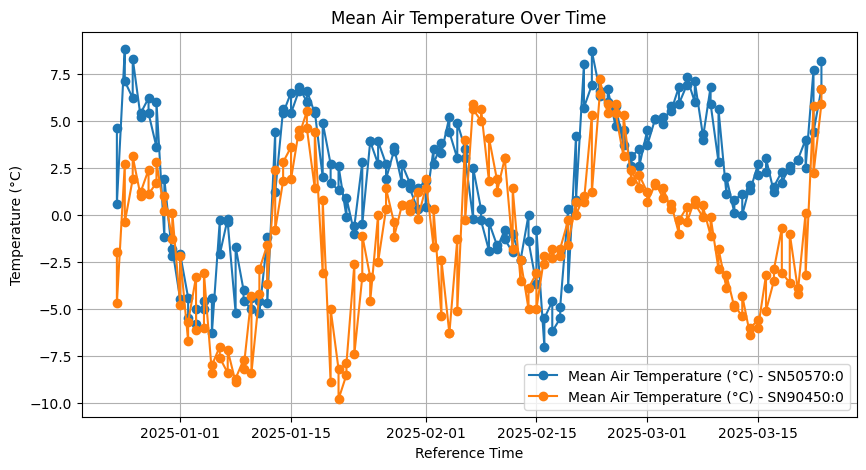

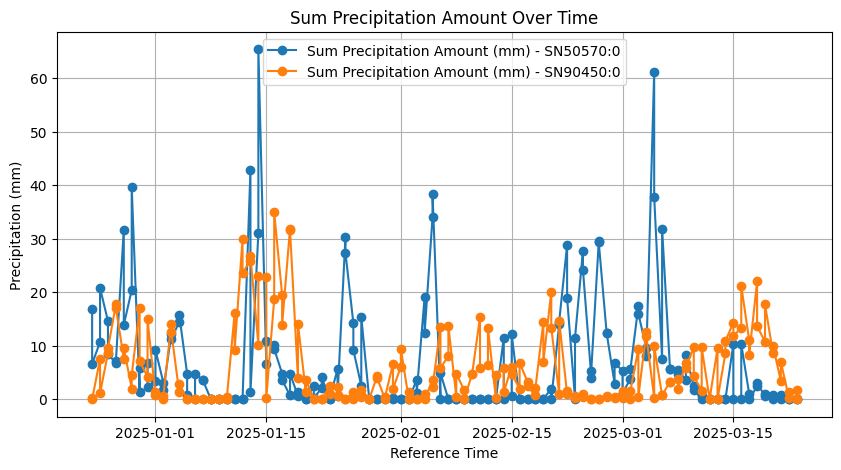

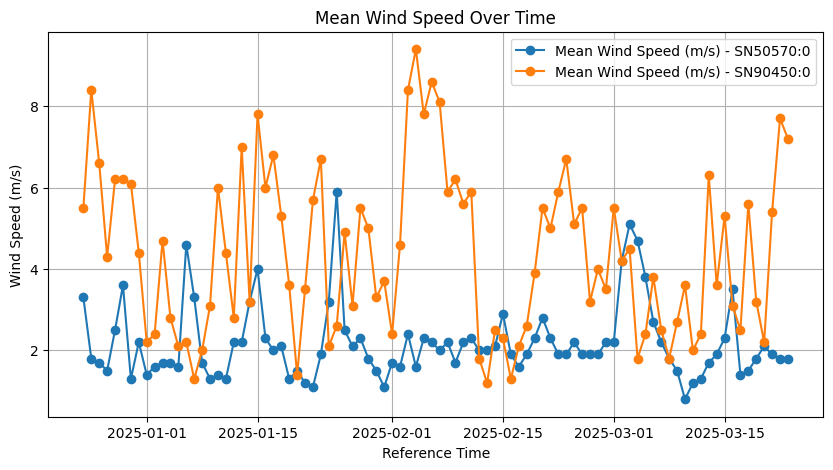

In [45]:
from geopy.geocoders import Nominatim
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
import certifi
from datetime import datetime, timedelta

# Sett opp SSL-sertifikat
os.environ["SSL_CERT_FILE"] = certifi.where()

# Geopy for å finne koordinater
geolocator = Nominatim(user_agent="Dataanalyseapplikasjon")

# Brukerinput for to steder
place1 = input("Skriv inn det første stedet (f.eks. Oslo, Norway): ")
place2 = input("Skriv inn det andre stedet (f.eks. Bergen, Norway): ")

# Finn koordinater for begge steder
location1 = geolocator.geocode(place1)
location2 = geolocator.geocode(place2)

if location1 and location2:
    print(f"Fant sted 1: {location1.address}")
    print(f"Koordinater: {location1.latitude}, {location1.longitude}")
    print(f"Fant sted 2: {location2.address}")
    print(f"Koordinater: {location2.latitude}, {location2.longitude}")

    # Frost API for å finne stasjoner
    client_id = '2e243d34-57bc-42b4-8095-239991af5353'
    endpoint_sources = 'https://frost.met.no/sources/v0.jsonld'

    # Finn nærmeste stasjon for sted 1
    parameters_sources1 = {
        'geometry': f'nearest(POINT({location1.longitude} {location1.latitude}))',
        'fields': 'id,name,geometry'
    }
    response_sources1 = requests.get(endpoint_sources, parameters_sources1, auth=(client_id, ''))
    if response_sources1.status_code == 200:
        sources1 = response_sources1.json()['data']
        station1_id = sources1[0]['id']
        print(f"Nærmeste stasjon for {place1}: {station1_id} - {sources1[0]['name']}")
    else:
        print(f"Feil ved henting av stasjoner for {place1}: {response_sources1.status_code}")
        exit()

    # Finn nærmeste stasjon for sted 2
    parameters_sources2 = {
        'geometry': f'nearest(POINT({location2.longitude} {location2.latitude}))',
        'fields': 'id,name,geometry'
    }
    response_sources2 = requests.get(endpoint_sources, parameters_sources2, auth=(client_id, ''))
    if response_sources2.status_code == 200:
        sources2 = response_sources2.json()['data']
        station2_id = sources2[0]['id']
        print(f"Nærmeste stasjon for {place2}: {station2_id} - {sources2[0]['name']}")
    else:
        print(f"Feil ved henting av stasjoner for {place2}: {response_sources2.status_code}")
        exit()

    # Frost API for å hente værdata
    endpoint_observations = 'https://frost.met.no/observations/v0.jsonld'
    now = datetime.now()
    offset = now - timedelta(days=90)
    current_date = now.strftime("%Y-%m-%d")
    historic_date = offset.strftime("%Y-%m-%d")

    parameters_observations = {
        'sources': f'{station1_id},{station2_id}',
        'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)',
        'referencetime': f'{historic_date}/{current_date}',
    }

    # Send forespørsel til Frost API for observasjoner
    response_observations = requests.get(endpoint_observations, parameters_observations, auth=(client_id, ''))
    if response_observations.status_code == 200:
        data = response_observations.json()['data']
        print("Værdata hentet fra Frost API!")

        # Prosesser data til DataFrame
        df_list = []
        for item in data:
            row = pd.DataFrame(item['observations'])
            row['referenceTime'] = item['referenceTime']
            row['sourceId'] = item['sourceId']
            df_list.append(row)

        df = pd.concat(df_list, ignore_index=True)

        # Plotting av data
        # Filtrer data etter elementId
        temperature_data = df[df['elementId'] == 'mean(air_temperature P1D)']
        precipitation_data = df[df['elementId'] == 'sum(precipitation_amount P1D)']
        wind_speed_data = df[df['elementId'] == 'mean(wind_speed P1D)']

        # Konverter referencetime til datetime
        temperature_data['referenceTime'] = pd.to_datetime(temperature_data['referenceTime'])
        precipitation_data['referenceTime'] = pd.to_datetime(precipitation_data['referenceTime'])
        wind_speed_data['referenceTime'] = pd.to_datetime(wind_speed_data['referenceTime'])

        # Plot mean air temperature
        plt.figure(figsize=(10, 5))
        for source_id, group in temperature_data.groupby('sourceId'):
            plt.plot(group['referenceTime'], group['value'], marker='o', label=f'Mean Air Temperature (°C) - {source_id}')
        plt.xlabel('Reference Time')
        plt.ylabel('Temperature (°C)')
        plt.title('Mean Air Temperature Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot sum precipitation amount
        plt.figure(figsize=(10, 5))
        for source_id, group in precipitation_data.groupby('sourceId'):
            plt.plot(group['referenceTime'], group['value'], marker='o', label=f'Sum Precipitation Amount (mm) - {source_id}')
        plt.xlabel('Reference Time')
        plt.ylabel('Precipitation (mm)')
        plt.title('Sum Precipitation Amount Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot mean wind speed
        plt.figure(figsize=(10, 5))
        for source_id, group in wind_speed_data.groupby('sourceId'):
            plt.plot(group['referenceTime'], group['value'], marker='o', label=f'Mean Wind Speed (m/s) - {source_id}')
        plt.xlabel('Reference Time')
        plt.ylabel('Wind Speed (m/s)')
        plt.title('Mean Wind Speed Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        print(f"Feil ved henting av værdata: {response_observations.status_code}")
        print(f"Melding: {response_observations.json()['error']['message']}")
else:
    print("Kunne ikke finne ett eller begge stedene. Prøv igjen.")

In [47]:
print(df)

                         elementId  value  unit  \
0        mean(air_temperature P1D)    4.6  degC   
1        mean(air_temperature P1D)    0.6  degC   
2    sum(precipitation_amount P1D)   16.8    mm   
3    sum(precipitation_amount P1D)    6.6    mm   
4             mean(wind_speed P1D)    3.3   m/s   
..                             ...    ...   ...   
895      mean(air_temperature P1D)    5.9  degC   
896      mean(air_temperature P1D)    6.7  degC   
897  sum(precipitation_amount P1D)    1.7    mm   
898  sum(precipitation_amount P1D)    0.0    mm   
899           mean(wind_speed P1D)    7.2   m/s   

                                                 level timeOffset  \
0    {'levelType': 'height_above_ground', 'unit': '...       PT0H   
1    {'levelType': 'height_above_ground', 'unit': '...       PT6H   
2                                                  NaN      PT18H   
3                                                  NaN       PT6H   
4    {'levelType': 'height_above_ground', 

In [46]:
from datetime import datetime, timedelta

now = datetime.now()

one_year_ago = now - timedelta(days=365)

# Hent dagens dato
current_date = datetime.now().date()

# Beregn datoen for ett år siden
date_time_1=one_year_ago.strftime("%Y-%m-%d")

date_time=now.strftime("%Y-%m-%d")

print(type(one_year_ago))
print(date_time_1)
print(type(date_time))

<class 'datetime.datetime'>
2024-03-24
<class 'str'>
